In [5]:
LIGHTCURVE = 'RESAMPLED_0100725706_20070516T060226'

# Carregando uma curva de luz

In [ ]:
!pip install C:/Users/guisa/Desktop/IMT-LightCurve/dist/imt_lightcurve-1.2-py3-none-any.whl --force-reinstall

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


from imt_lightcurve.models.lightcurve import LightCurve

# Chosen a LightCurve to simulation process


curve_id = int(LIGHTCURVE.split('_')[1][1:])

# Importing lightcurve data from github
data = pd.read_csv('https://raw.githubusercontent.com/Guilherme-SSB/IC-CoRoT_Kepler/main/resampled_files/' + LIGHTCURVE + '.csv')
flux = data.WHITEFLUX.to_numpy()
# flux = flux/np.median(flux)
time = np.arange(0, len(flux))

curve = LightCurve(time, flux)
# curve.plot()

P = LightCurve.get_true_value(curve_id, 'Per')
print(f'Period is {round(P, 4)} days')

Period is 13.2402 days


# Determinar picos dos eclipses

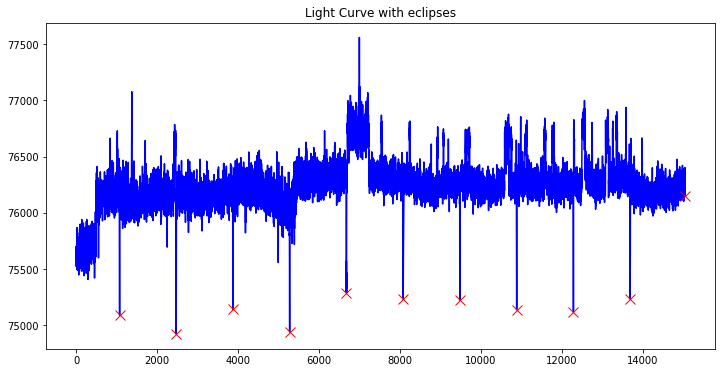

In [7]:
from scipy.signal import find_peaks# , peak_prominences, peak_widths

inverted_curve = LightCurve(time=curve.time, flux=-1*curve.flux)

x = inverted_curve.flux
peaks, _ = find_peaks(x, distance=P*100)

# Plotting 
plt.figure(figsize=(12, 6))
plt.plot(curve.flux, color='b')
plt.plot(peaks, -1*x[peaks], 'x', color='r', markersize=10)
plt.title('Light Curve with eclipses')
plt.show()

In [8]:
peaks

array([ 1072,  2471,  3871,  5275,  6679,  8081,  9482, 10888, 12291,
       13693, 15047], dtype=int64)

# Determinar largura dos eclipses

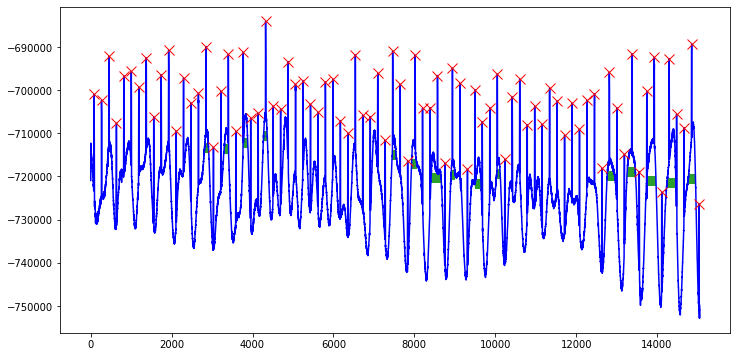

In [5]:
from scipy.signal import peak_widths

results_half = peak_widths(x, peaks, rel_height=0.5)
results_full = peak_widths(x, peaks, rel_height=1)

plt.figure(figsize=(12, 6))
plt.plot(x, color='b')
plt.plot(peaks, x[peaks], 'x', color='r', markersize=10)
plt.hlines(*results_half[1:], color='C2', linewidths=10)
# plt.hlines(*results_full[1:], color="C3")
plt.show()

zoom...

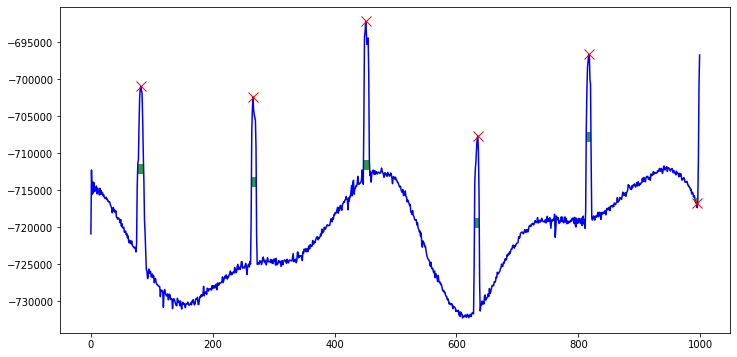

In [6]:
x_zoom = inverted_curve.flux[:1000]

peaks_zoom, _ = find_peaks(x_zoom, distance=P*100)
results_half_zoom = peak_widths(x_zoom, peaks_zoom, rel_height=0.5)
results_full_zoom = peak_widths(x_zoom, peaks_zoom, rel_height=1)

plt.figure(figsize=(12, 6))
plt.plot(x_zoom, color='b')
plt.plot(peaks_zoom, x_zoom[peaks_zoom], 'x', color='r', markersize=10)
plt.hlines(*results_half_zoom[1:], color='C2', linewidths=10)
# plt.hlines(*results_full_zoom[1:], color="C3")
plt.show()

In [7]:
eclipse_width_mean = np.mean(results_half[0]); eclipse_width_mean

34.18792636280537

# Fold Curve

In [8]:
#@title Fold function
import lightkurve as lk

def fold(time: np.ndarray, flux: np.ndarray, period: float, eclipse_width: int, plotting = False):
  kurve = lk.LightCurve(time=time, flux=flux)
  # if plotting:
  #   kurve.plot()
  #   plt.title('Raw Light Curve ')
  #   plt.show()
  normalized_kurve = kurve.normalize()

  # Creating a lightcurve with flux inverted
  time_arange = np.arange(0, len(normalized_kurve.time.value))
  inverted_normalized_kurve = lk.LightCurve(time=time_arange, flux=-1*normalized_kurve.flux.value)

  # Renaming
  analysis_curve = inverted_normalized_kurve

  # Finding peaks
  x = analysis_curve.flux.value
  peaks, _ = find_peaks(x, distance=period*100)


  peaks = peaks[1:-1]

  # Plotting 
  if plotting:
    print()
    normalized_kurve.plot()
    plt.plot(peaks, -1*x[peaks], "x")
    plt.title('Inverted-Light Curve with peaks')
    plt.show()

  # Eclipses analysis
  totalEclipses = len(peaks)
  print(f'\n\nThis light curve has {totalEclipses} eclipses\n\n')

  # Summing all eclipses
  sum_eclipses_flux = 0
  for numEclipse in range(totalEclipses):
    cond = (analysis_curve.time.value > (peaks[numEclipse]-eclipse_width/2)) & (analysis_curve.time.value < (peaks[numEclipse]+eclipse_width/2))
    sum_eclipses_flux += analysis_curve.flux.value[cond]

  sum_eclipses_flux *= -1

  ## Computing the average eclipse
  avg_eclipse_total = sum_eclipses_flux / totalEclipses

  time_plot = np.arange(-len(avg_eclipse_total)/2, len(avg_eclipse_total)/2)

  ## Return
  return LightCurve(time_plot, avg_eclipse_total)

In [9]:
curve.plot(title=f'CoRoT ID: {curve_id}')

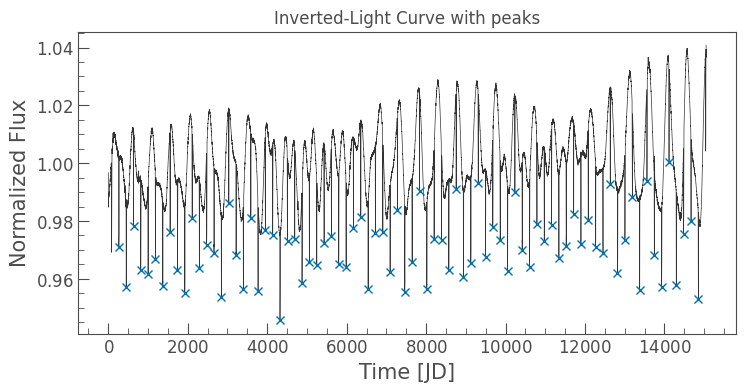



This light curve has 80 eclipses




In [10]:
folded_curve = fold(time, curve.flux, P, eclipse_width_mean, plotting=True); folded_curve.plot(title=f'CoRoT ID: {curve_id}')

In [11]:
help(curve.fold)

Help on method fold in module imt_lightcurve.models.lightcurve:

fold(smooth_curve: bool = False, window: float = 0.15, window_filter: int = 201, order_filter: int = 3) method of imt_lightcurve.models.lightcurve.LightCurve instance



In [15]:
curve.fold(curve_id).plot()

`period` contains 8153006 points.Periodogram is likely to be large, and slow to evaluate. Consider setting `frequency_factor` to a higher value.


Salvando resultado para testar na simulação

In [ ]:
np.savetxt('time_folded.txt', folded_curve.time, delimiter='\n', fmt='%.9f')
np.savetxt('flux_folded.txt', folded_curve.flux, delimiter='\n', fmt='%.9f')

# Relatório final do algoritmo

In [ ]:
# relatorio_final = pd.read_excel('/content/Analise Fold Function.xlsx'); display(relatorio_final)

# Pergunta: ajusta uma gaussiana ou não ?
Eu acho bom, mas nao sei a modelagem foi feita em cima de gaussianas